/var/folders/x6/y_1j77ld0lndn2rh5d1xn9tw0000gn/T/ipykernel_49495/1126312400.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


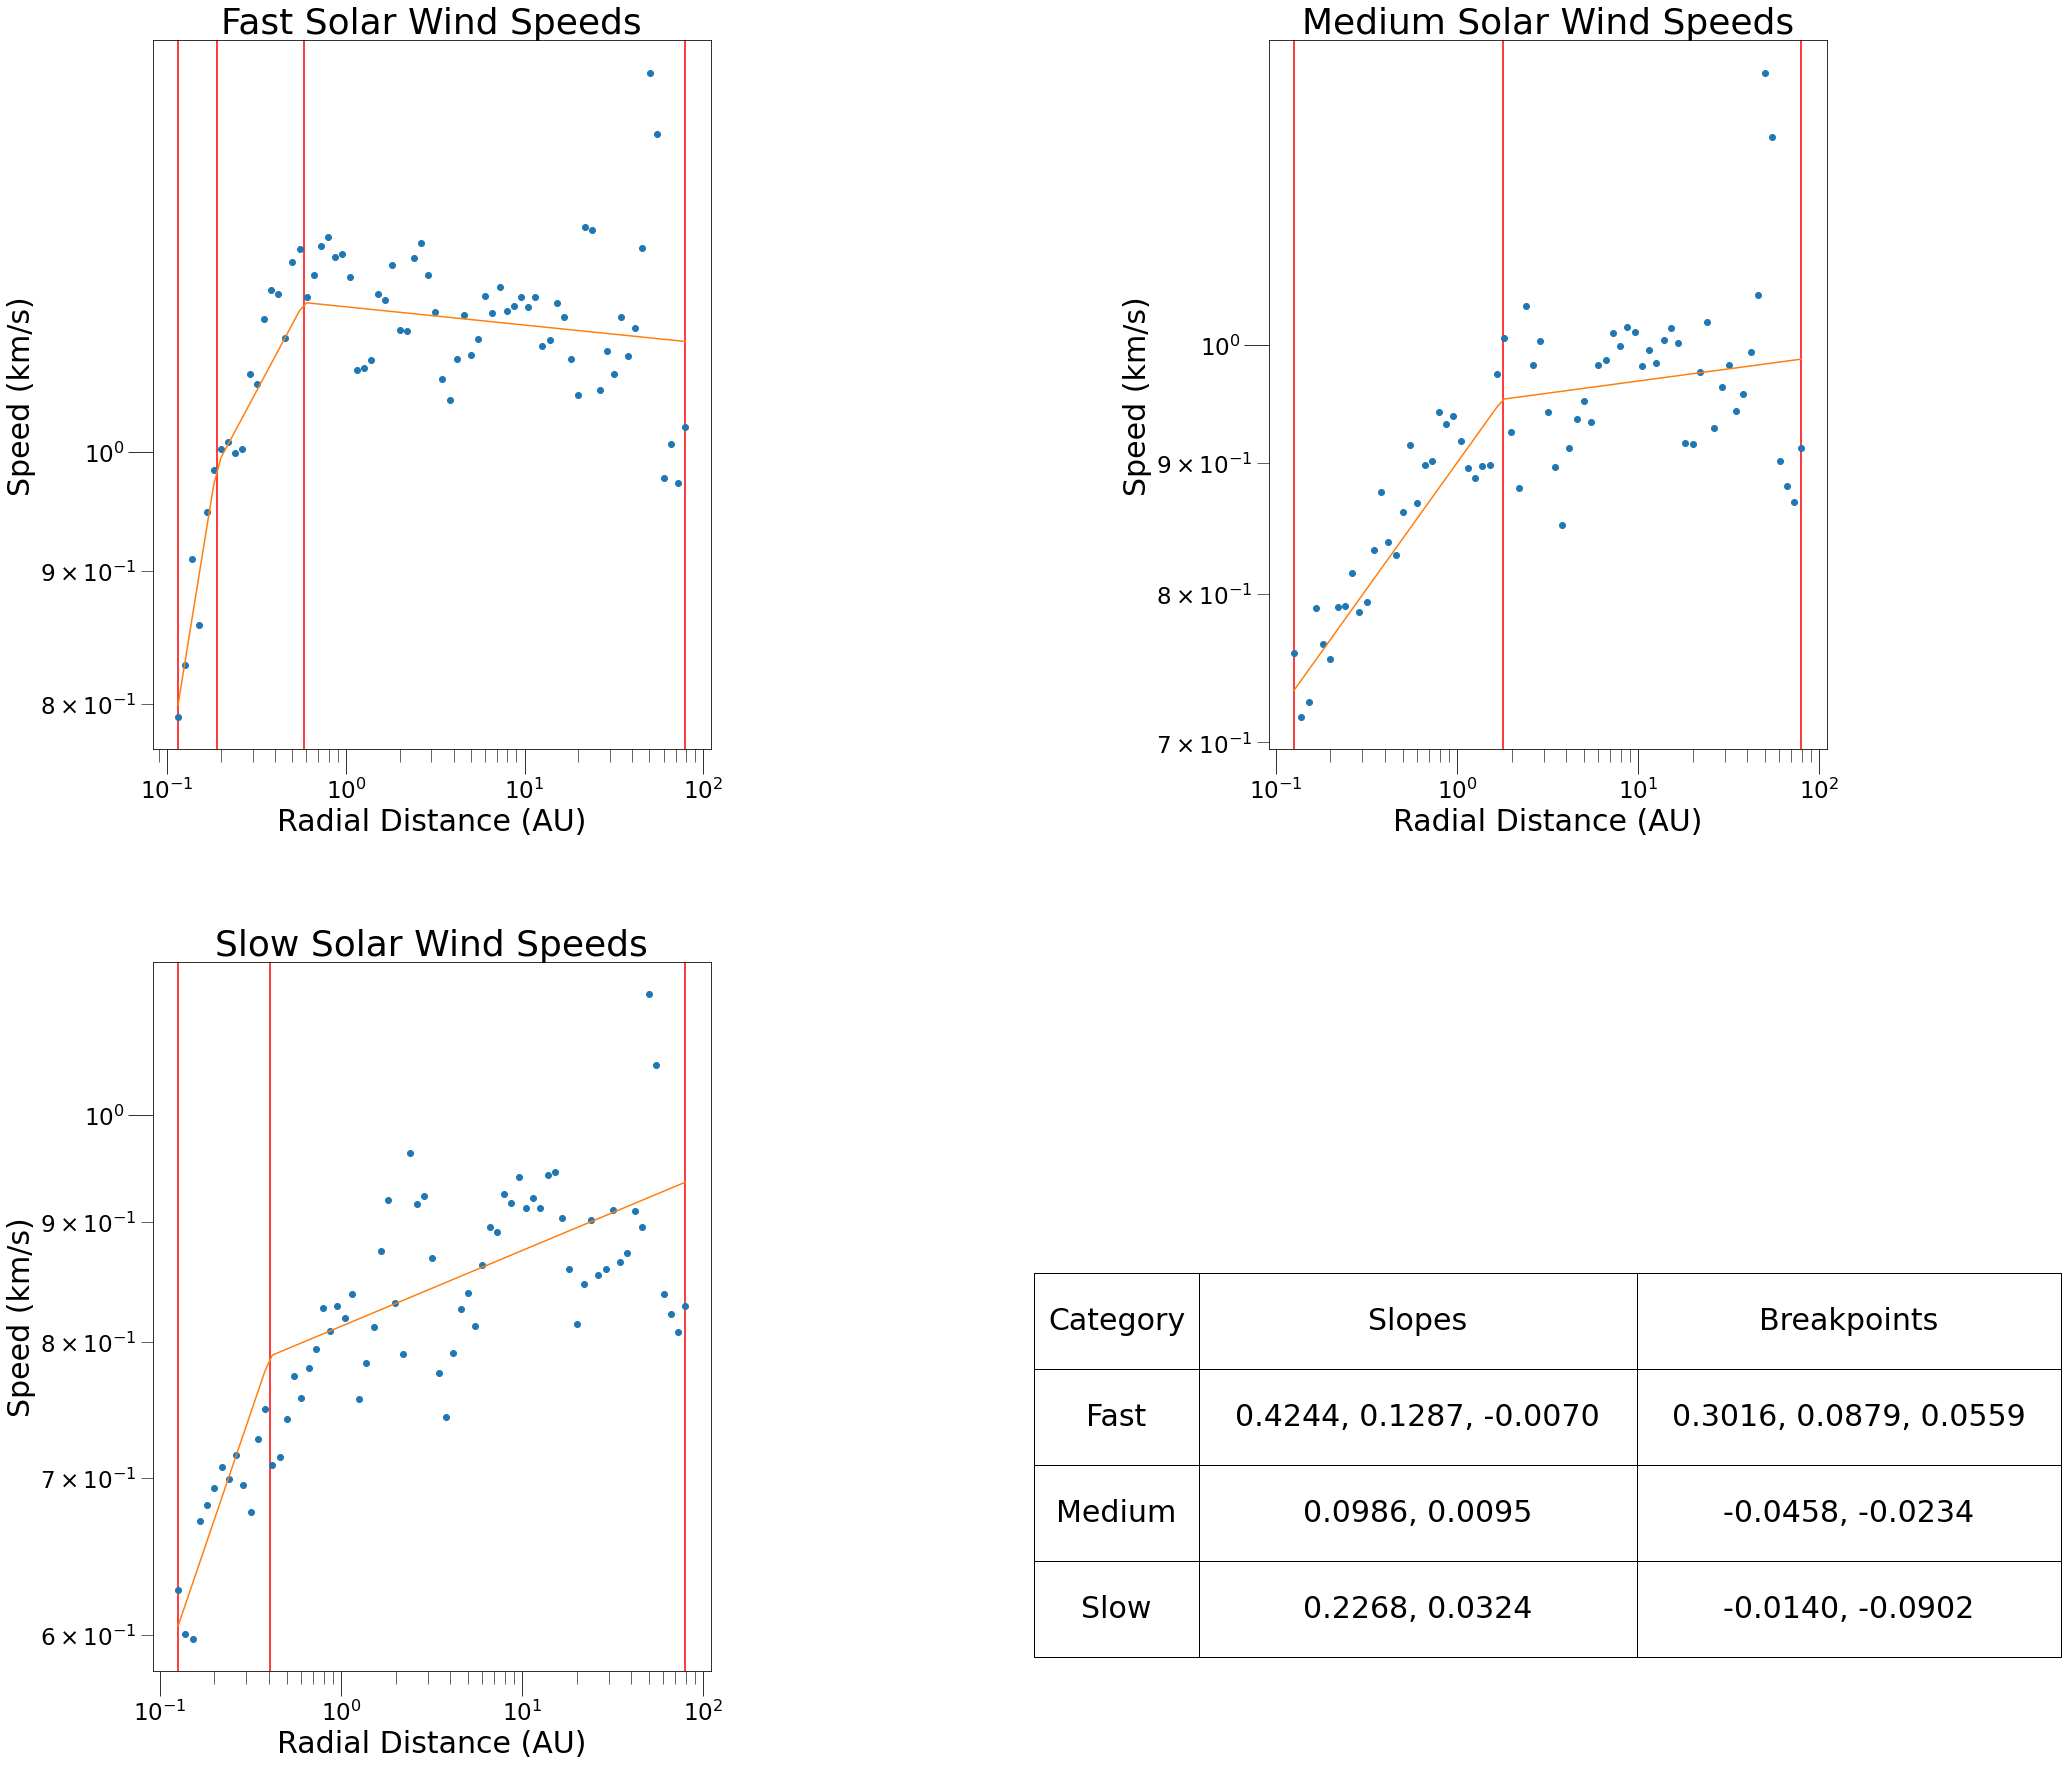

/var/folders/x6/y_1j77ld0lndn2rh5d1xn9tw0000gn/T/ipykernel_49495/1126312400.py:415: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


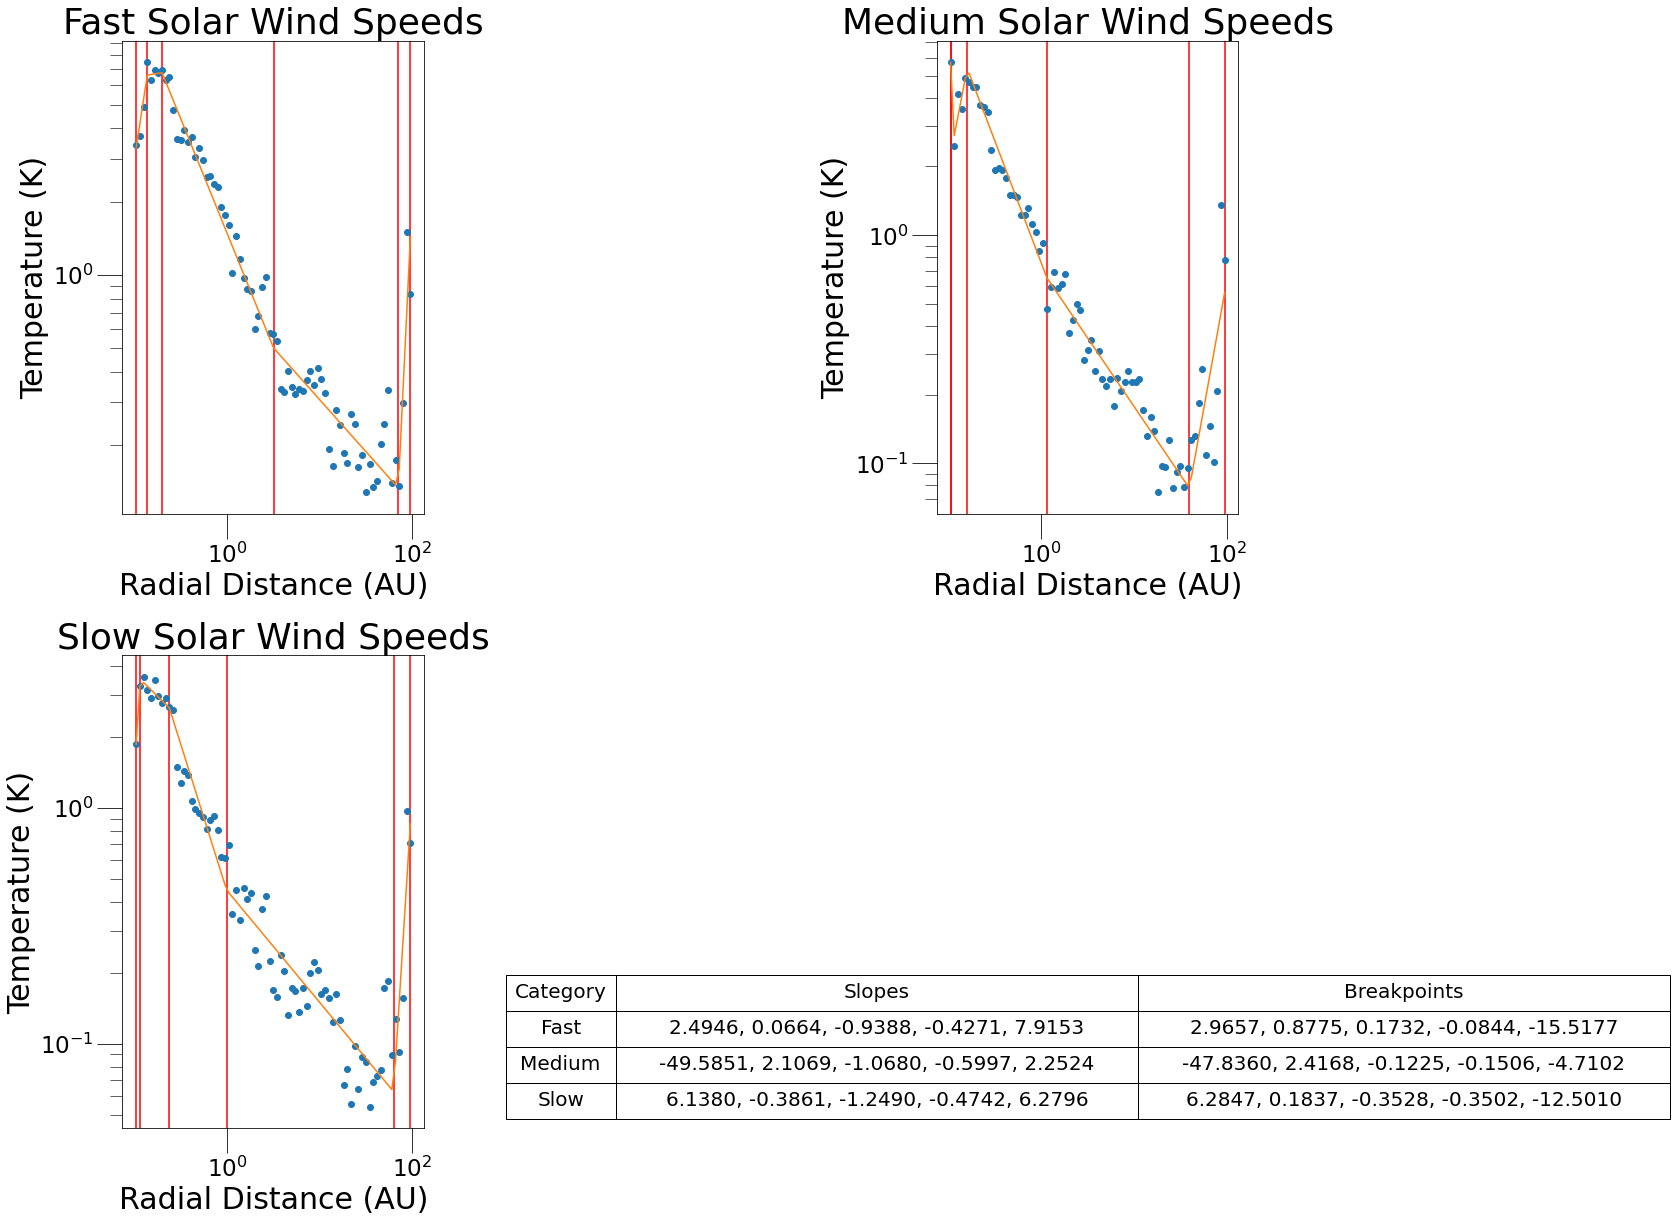

/var/folders/x6/y_1j77ld0lndn2rh5d1xn9tw0000gn/T/ipykernel_49495/1126312400.py:415: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


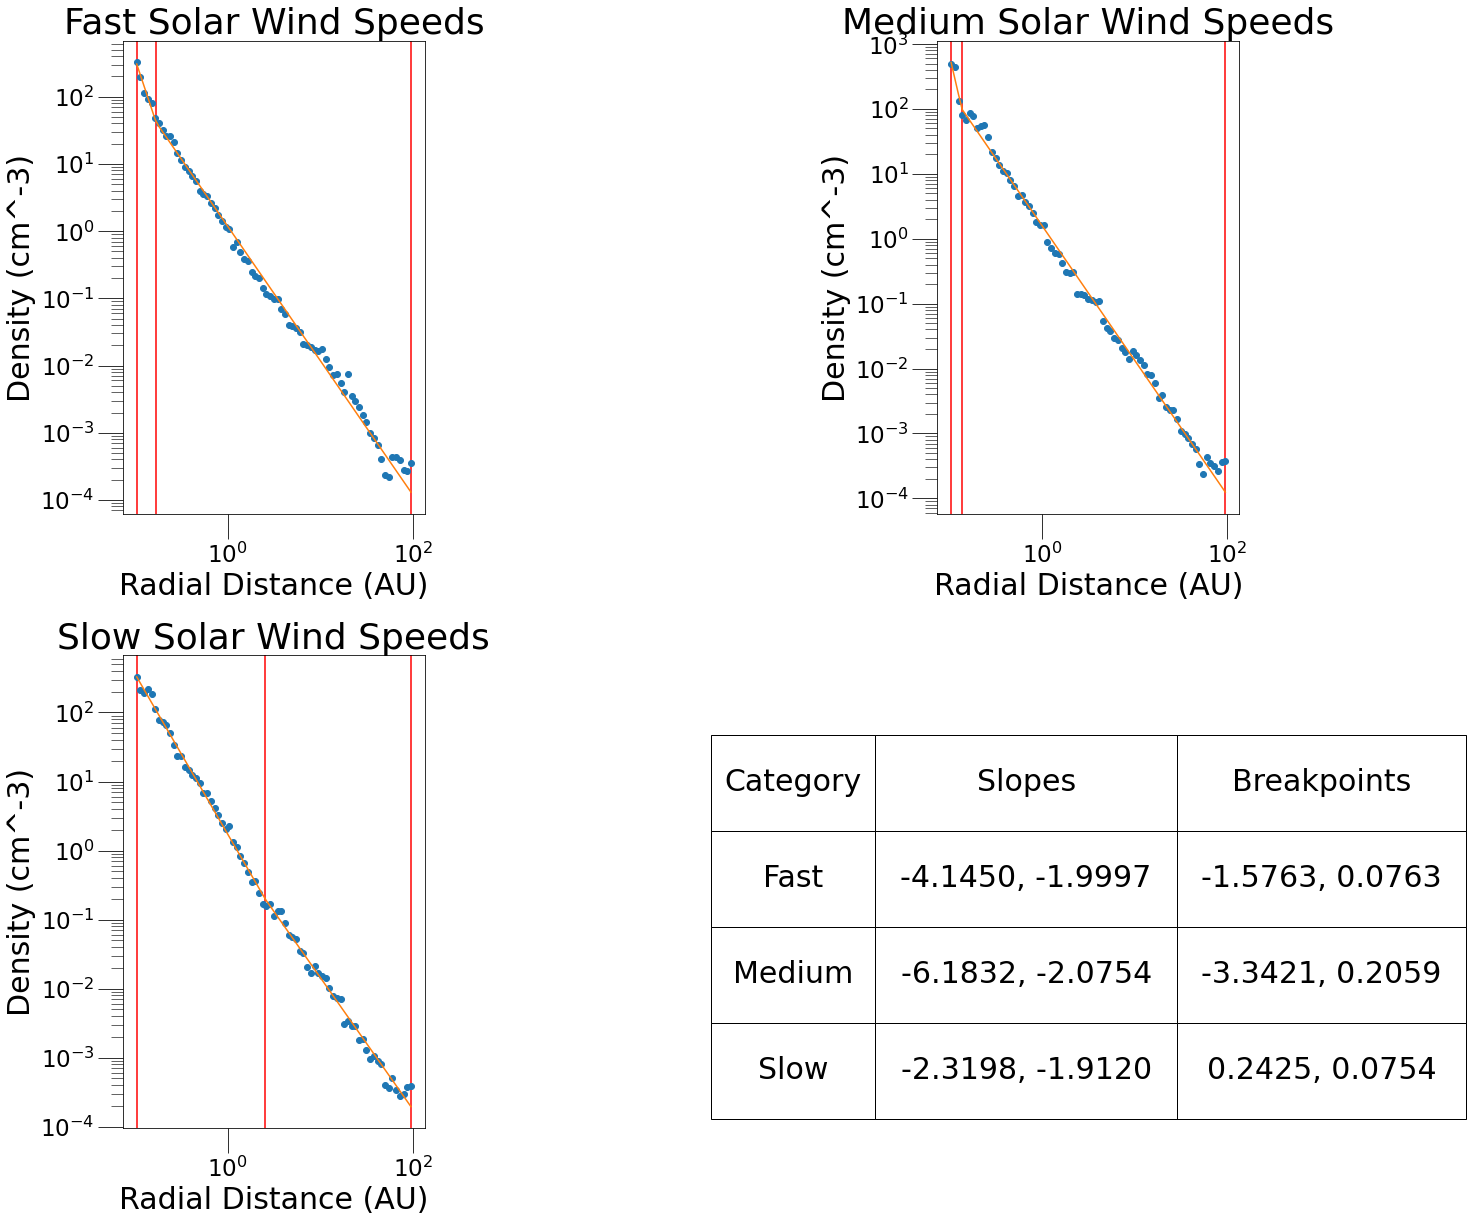

/var/folders/x6/y_1j77ld0lndn2rh5d1xn9tw0000gn/T/ipykernel_49495/1126312400.py:475: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


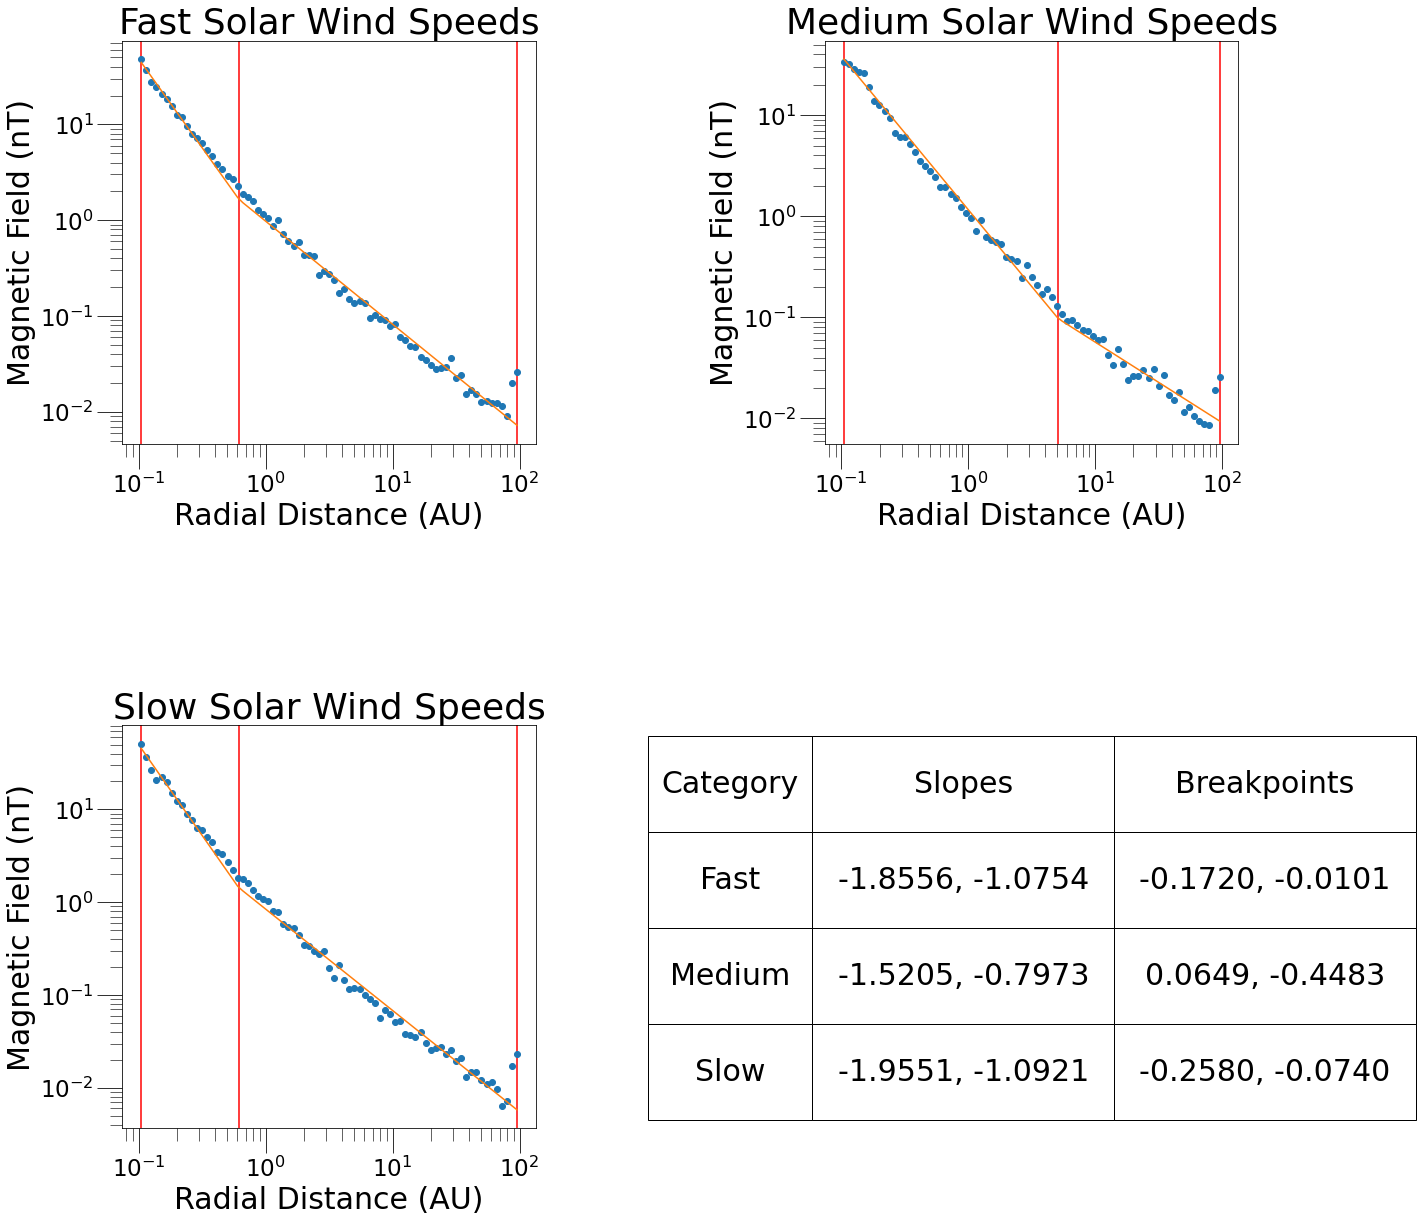

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import chi2
import pwlf
import math

###################################### FUNCTIONS #################################


def plotting_function(
    param,
    mid_points_list,
    param_list,
    weights_list,
    mode,
    ax,
    breakpoint_number,
    fontsize,
):

    # Generate the model using a package implementing curve_fit
    my_pwlf = pwlf.PiecewiseLinFit(
        np.log10(mid_points_list), np.log10(param_list), weights=weights_list
    )
    breaks = my_pwlf.fit(breakpoint_number)

    predicted_y = my_pwlf.predict(np.log10(mid_points_list))

    # Plot the data
    ax.set_xscale("log")
    ax.set_yscale("log")
    for b in breaks:
        ax.axvline(10**b, color="r")
    ax.plot(mid_points_list, param_list, "o")
    ax.plot(mid_points_list, 10**predicted_y, "-")
    if param == "vp_m":
        ax.set_ylabel("Speed (km/s)", fontsize=fontsize)
    elif param == "np":
        ax.set_ylabel("Density (cm^-3)", fontsize=fontsize)
    elif param == "Tp":
        ax.set_ylabel("Temperature (K)", fontsize=fontsize)
    elif param == "bm":
        ax.set_ylabel("Magnetic Field (nT)", fontsize=fontsize)
    ax.set_xlabel("Radial Distance (AU)", fontsize=fontsize)
    ax.set_title(f"{mode} Solar Wind Speeds", fontsize=1.2 * fontsize)
    tick_size = 25
    label_size = 23
    ax.tick_params(axis="both", which="major", labelsize=label_size, length=tick_size)
    ax.tick_params(
        axis="both", which="minor", labelsize=label_size, length=tick_size / 2
    )

    # Calculate statistics
    slopes = my_pwlf.slopes
    intercepts = my_pwlf.intercepts
    observed = param_list
    predicted = 10**predicted_y
    degrees_freedom = len(observed) - len(slopes) - len(intercepts) - 1
    chi_squared_stat, p_value, fit_result = chi_squared_test(
        observed, predicted, degrees_freedom
    )

    # Prepare table data
    table_data = [
        ["Category", mode],
        ["Slopes", ", ".join(f"{s:.4f}" for s in slopes)],
        ["Intercepts", ", ".join(f"{i:.4f}" for i in intercepts)],
        ["Chi-squared stat", f"{chi_squared_stat:.4f}"],
        ["P-value", f"{p_value:.4f}"],
        ["Breakpoints", ", ".join(f"{b:.4f}" for b in breaks)],
    ]

    return table_data


# Function to calculate weights (inverse of the standard deviation in each bin)
def calculate_weights(df, category):
    weights_1 = df[df["wind_speed_category"] == category].groupby("bins")["vp_m"].size()
    total = df[df["wind_speed_category"] == category].groupby("bins")["vp_m"].count()
    weights_2 = np.sqrt(weights_1) / total
    weights_2 = weights_2.fillna(0).tolist()
    return weights_2


# Function to compute the Chi-squared statistic for each model
def chi_squared_test(observed, predicted, degrees_freedom, alpha=0.05):

    squared_residuals = [
        (obs - pred) ** 2 / pred for obs, pred in zip(observed, predicted)
    ]
    chi_squared_stat = sum(squared_residuals)

    p_value = 1 - chi2.cdf(chi_squared_stat, degrees_freedom)

    if p_value < alpha:
        fit_result = False
    else:
        fit_result = True

    return chi_squared_stat, p_value, fit_result


def clean_lists(mid_points_list, params_list, weights_list):

    valid_mid_points = []
    valid_params_list = []
    valid_weights = []

    for mid_point, bm, weight in zip(mid_points_list, params_list, weights_list):
        try:
            log_mid_point = np.log10(mid_point)
            log_bm = np.log10(bm)
            # Check if log values are finite (not inf or NaN)
            if np.isfinite(log_mid_point) and np.isfinite(log_bm):
                # If both values are valid, append to the new lists
                valid_mid_points.append(log_mid_point)
                valid_params_list.append(log_bm)
                valid_weights.append(weight)
        except (ValueError, OverflowError):
            # Skip invalid values
            continue

    return valid_mid_points, valid_params_list, valid_weights


def table_formatter(param, results, grid):

    columns = ["Category", "Slopes", "Breakpoints"]
    table_data = []

    for result in results:
        if isinstance(result, list) and len(result) >= 3:
            category = result[0]
            slopes = result[1]
            breakpoints = result[2]

            # Extract just the value, removing any labels
            category_value = (
                category[1]
                if isinstance(category, (list, tuple)) and len(category) > 1
                else category
            )

            # For slopes and breakpoints, extract the numeric value
            slopes_value = (
                slopes[1]
                if isinstance(slopes, (list, tuple)) and len(slopes) > 1
                else slopes
            )
            breakpoints_value = (
                breakpoints[1]
                if isinstance(breakpoints, (list, tuple)) and len(breakpoints) > 1
                else breakpoints
            )

            # Remove any remaining quotes
            slopes_value = (
                slopes_value.strip("'")
                if isinstance(slopes_value, str)
                else slopes_value
            )
            breakpoints_value = (
                breakpoints_value.strip("'")
                if isinstance(breakpoints_value, str)
                else breakpoints_value
            )

            row = [category_value, slopes_value, breakpoints_value]
            table_data.append(row)
        else:
            print(f"Unexpected result format: {result}")

    # Add the header row at the beginning
    table_data.insert(0, columns)

    # Add the aggregated table to the fourth subplot
    grid.axis("tight")
    grid.axis("off")
    table = grid.table(cellText=table_data, cellLoc="center", loc="lower center")
    table.auto_set_font_size(False)
    if param == "Tp":
        table.set_fontsize(20)
        table.scale(1, 3.0)
    else:
        table.set_fontsize(30)
        table.scale(1, 8.0)

    # Auto-adjust the column widths
    table.auto_set_column_width(col=list(range(len(table_data[0]))))


def main_function(param):

    df = pd.read_pickle("all_spcaecraft_data_scaled_v2024.05.p")

    df.dropna(subset=["sc_r", "vp_m"], inplace=True)
    df = df[df["vp_m"] > 0]

    if param == "bm":
        df = df[df["bm"] > 0]

    # Define bins and calculate geometric midpoints
    bins = np.logspace(np.log10(0.1), np.log10(100), 76)
    labels = range(len(bins) - 1)
    df["bins"] = pd.cut(df["sc_r"], bins=bins, include_lowest=True, labels=labels)
    mid_points = np.sqrt(bins[:-1] * bins[1:])
    mid_points_list = mid_points.tolist()

    # Calculate percentile cutoffs within each bin
    percentile_cutoffs = df.groupby("bins")["vp_m"].quantile([0.30, 0.40]).unstack()

    # Rename columns for clarity
    percentile_cutoffs.columns = ["p30", "p40"]

    # Merge percentile cutoffs into the main DataFrame
    df = df.join(percentile_cutoffs, on="bins")

    # Label data with wind speed categories
    conditions = [
        df["vp_m"] <= df["p30"],
        (df["vp_m"] > df["p30"]) & (df["vp_m"] <= df["p40"]),
        df["vp_m"] > df["p40"],
    ]
    choices = ["slow", "medium", "fast"]
    df["wind_speed_category"] = np.select(conditions, choices, default="fast")

    # Filter out rows with NaN means before plotting or modeling
    df.dropna(subset=["p30", "p40"], inplace=True)

    # Group by bins and wind_speed_category and calculate the mean vp_m for each group
    mean_param = df.groupby(["bins", "wind_speed_category"])[param].mean().unstack()

    # Create lists for the average vp_m values per bin for each category
    param_slow = mean_param["slow"].tolist()
    param_medium = mean_param["medium"].tolist()
    param_fast = mean_param["fast"].tolist()

    # Calculate weights for each category
    weights_slow = calculate_weights(df, "slow")
    weights_medium = calculate_weights(df, "medium")
    weights_fast = calculate_weights(df, "fast")

    if param == "vp_m":

        fig, axs = plt.subplots(
            2, 2, figsize=(30, 30), gridspec_kw={"hspace": 0.3, "wspace": 1.0}
        )

        axs[0, 0].set_aspect("auto")
        axs[0, 1].set_aspect("auto")
        axs[1, 0].set_aspect("auto")
        grid = axs[1, 1]
        grid.set_aspect("auto")

        results = []
        breakpoint_number = 3

        # Analysis for the fast solar wind speeds
        highest_value_x = max(mid_points_list)
        highest_value_y_index = mid_points_list.index(highest_value_x)
        param_fast.pop(highest_value_y_index)
        mid_points_list_fast = mid_points_list.copy()
        mid_points_list_fast.remove(highest_value_x)
        weights_fast.pop(highest_value_y_index)

        second_highest_value_x = max(mid_points_list_fast)
        second_highest_value_y_index = mid_points_list_fast.index(
            second_highest_value_x
        )
        param_fast.pop(second_highest_value_y_index)
        mid_points_list_fast.remove(second_highest_value_x)
        weights_fast.pop(second_highest_value_y_index)

        lowest_value_x = min(mid_points_list_fast)
        lowest_value_y_index = mid_points_list_fast.index(lowest_value_x)
        param_fast.pop(lowest_value_y_index)
        mid_points_list_fast.remove(lowest_value_x)
        weights_fast.pop(lowest_value_y_index)
        fast_results = plotting_function(
            param,
            mid_points_list_fast,
            param_fast,
            weights_fast,
            mode="Fast",
            ax=axs[0, 0],
            breakpoint_number=breakpoint_number,
            fontsize=30,
        )
        results.append(fast_results)

        # Analysis for the Medium Solar Wind Speeds
        mid_points_list_medium = mid_points_list_fast.copy()
        param_medium.pop(highest_value_y_index)
        param_medium.pop(second_highest_value_y_index)
        weights_medium.pop(highest_value_y_index)
        weights_medium.pop(second_highest_value_y_index)

        param_medium.pop(lowest_value_y_index)
        weights_medium.pop(lowest_value_y_index)

        second_lowest_value_x = min(mid_points_list_medium)
        second_lowest_value_y_index = mid_points_list_medium.index(
            second_lowest_value_x
        )
        param_medium.pop(second_lowest_value_y_index)
        mid_points_list_medium.remove(second_lowest_value_x)
        weights_medium.pop(second_lowest_value_y_index)
        breakpoint_number = 2
        medium_results = plotting_function(
            param,
            mid_points_list_medium,
            param_medium,
            weights_medium,
            mode="Medium",
            ax=axs[0, 1],
            breakpoint_number=breakpoint_number,
            fontsize=30,
        )
        results.append(medium_results)

        # Analysis for the Slow Solar Wind Speeds
        mid_points_list_slow = mid_points_list_medium.copy()
        param_slow.pop(highest_value_y_index)
        param_slow.pop(second_highest_value_y_index)
        weights_slow.pop(highest_value_y_index)
        weights_slow.pop(second_highest_value_y_index)

        param_slow.pop(lowest_value_y_index)
        weights_slow.pop(lowest_value_y_index)
        param_slow.pop(second_lowest_value_y_index)
        weights_slow.pop(second_lowest_value_y_index)
        slow_results = plotting_function(
            param,
            mid_points_list_slow,
            param_slow,
            weights_slow,
            mode="Slow",
            ax=axs[1, 0],
            breakpoint_number=breakpoint_number,
            fontsize=30,
        )
        results.append(slow_results)

        table_formatter(param, results, grid)

        plt.tight_layout()
        plt.savefig("solar_winds_analysis_speed.png", dpi=100, bbox_inches="tight")
        plt.show()

    elif param == "np" or param == "Tp":

        if param == "np":
            breakpoint_number = 2

        elif param == "Tp":
            breakpoint_number = 5

        fig, axs = plt.subplots(
            2, 2, figsize=(20, 20), gridspec_kw={"hspace": 0.3, "wspace": 1.7}
        )
        axs[0, 0].set_aspect("auto")
        axs[0, 1].set_aspect("auto")
        axs[1, 0].set_aspect("auto")
        grid = axs[1, 1]
        grid.set_aspect("auto")

        results = []

        # Analysis for the fast solar wind speeds
        fast_results = plotting_function(
            param,
            mid_points_list,
            param_fast,
            weights_fast,
            mode="Fast",
            ax=axs[0, 0],
            breakpoint_number=breakpoint_number,
            fontsize=30,
        )
        results.append(fast_results)

        # Analysis for the Medium Solar Wind Speeds
        medium_results = plotting_function(
            param,
            mid_points_list,
            param_medium,
            weights_medium,
            mode="Medium",
            ax=axs[0, 1],
            breakpoint_number=breakpoint_number,
            fontsize=30,
        )
        results.append(medium_results)

        # Analysis for the Slow Solar Wind Speeds
        slow_results = plotting_function(
            param,
            mid_points_list,
            param_slow,
            weights_slow,
            mode="Slow",
            ax=axs[1, 0],
            breakpoint_number=breakpoint_number,
            fontsize=30,
        )
        results.append(slow_results)

        table_formatter(param, results, grid)

        plt.tight_layout()
        if param == "np":
            plt.savefig("solar_winds_analysis_np.png", dpi=100, bbox_inches="tight")
            plt.show()
        elif param == "Tp":
            plt.savefig("solar_winds_analysis_Tp.png", dpi=100, bbox_inches="tight")
            plt.show()

    elif param == "bm":

        fig, axs = plt.subplots(
            2, 2, figsize=(20, 20), gridspec_kw={"hspace": 0.7, "wspace": 0.7}
        )

        axs[0, 0].set_aspect("auto")
        axs[0, 1].set_aspect("auto")
        axs[1, 0].set_aspect("auto")
        grid = axs[1, 1]
        grid.set_aspect("auto")

        results = []
        breakpoint_number = 2

        fast_results = plotting_function(
            param,
            mid_points_list,
            param_fast,
            weights_fast,
            mode="Fast",
            ax=axs[0, 0],
            breakpoint_number=breakpoint_number,
            fontsize=30,
        )
        results.append(fast_results)

        medium_results = plotting_function(
            param,
            mid_points_list,
            param_medium,
            weights_medium,
            mode="Medium",
            ax=axs[0, 1],
            breakpoint_number=breakpoint_number,
            fontsize=30,
        )
        results.append(medium_results)

        slow_results = plotting_function(
            param,
            mid_points_list,
            param_slow,
            weights_slow,
            mode="Slow",
            ax=axs[1, 0],
            breakpoint_number=breakpoint_number,
            fontsize=30,
        )
        results.append(slow_results)

        table_formatter(param, results, grid)
        plt.tight_layout()
        plt.savefig("solar_winds_analysis_bm.pdf", dpi=100, bbox_inches="tight")
        plt.show()


##################################################################################


parameters = ["vp_m", "Tp", "np", "bm"]

for param in parameters:

    main_function(param)

    print()


